In [ ]:
import math
import random
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
class Server:
    def __init__(self, utility):
        self.true_utility = utility
        self.queue_length = 0
        self.dispatchers = []
        self.total_files_processed = 0
        self.observed_utilities = []
        self.total_utilities_gained = 0
        self.total_observed_utilities = 0
        self.service_rates = []
        self.max_files_processed = 0

    def process_files(self, rate):
        count = min(rate, self.queue_length)
        self.queue_length -= count
        self.service_rates.append(rate)
        self.max_files_processed += rate
        self.total_files_processed += count
        self.total_utilities_gained += (count * self.true_utility)

        for i in range(count):
            errors = [0, 1, 2, 3]
            probabilities = [0.4, 0.35, 0.23, 0.02]
            error = random.choices(errors, probabilities)[0]
            utility_gained = self.true_utility + random.choice([error, -error])
            self.observed_utilities.append(utility_gained)
            self.total_observed_utilities += utility_gained

In [ ]:
def static_policy(k, Jobs, servers, T, Service_rates):
    M = len(servers)
    for t in range(T):
        jobs = Jobs[t]
        for m in range(M):
            tasks = min(jobs, random.randint(1, 15))
            jobs -= tasks
            if(m == M-1):
                tasks += jobs
            servers[m].queue_length += tasks
            service_rate = random.choice(Service_rates)
            servers[m].process_files(service_rate)

In [ ]:
def priority_k(k, jobs, Ordering, servers):
    M = len(servers)
    for i in range(M):
        if jobs <= 0:
            break

        m = Ordering[i] - 1
        if servers[m].queue_length < k:
            available = k - servers[m].queue_length
            if available < jobs:
                servers[m].queue_length = k
                jobs -= available
            elif available >= jobs:
                servers[m].queue_length += jobs
                jobs = 0

    if jobs > 0:
        servers[M - 1].queue_length += jobs
        jobs = 0

In [ ]:
def priority_k_driver(k, Jobs, servers, T, Service_rates):
    for t in range(T):
        jobs = Jobs[t]
        priority_k(k, jobs, Ordering, servers)
        for m in range(M):
            service_rate = random.choice(Service_rates)
            servers[m].process_files(service_rate)

In [ ]:
def get_new_Ordering(servers):
    dic = {}
    M = len(servers)

    for m in range(M):
        if servers[m].total_files_processed != 0:
            Vm = servers[m].total_observed_utilities / servers[m].total_files_processed
        else:
            Vm = -m
        dic[Vm] = m
        # print(dic)

    sorted_items = sorted(dic.items(), key=lambda item: item[0], reverse=True)
    new_Ordering = []
    for k, v in sorted_items:
        new_Ordering.append(v+1)

    return new_Ordering

In [ ]:
def upper_confidence_priority_k(k, Jobs, Ordering_UCPK, servers, T, Service_rates):
    Ordering_copy = [0] * len(Ordering_UCPK)
    M = len(servers)

    t = 0
    while t<T:
        if Ordering_UCPK == Ordering_copy:
            jobs = Jobs[t]
            priority_k(k, jobs, Ordering_UCPK, servers)
            for m in range(M):
                service_rate = random.choice(Service_rates)
                servers[m].process_files(service_rate)
            Ordering_UCPK = get_new_Ordering(servers)
            t = t + 1
        else:
            Ordering_copy = Ordering_UCPK
            m = 0
            jobs = Jobs[t]

            for m in range(M):
                if(m == M-1):
                    servers[m].queue_length += jobs % M
                else:
                    servers[m].queue_length += jobs // M
                service_rate = random.choice(Service_rates)
                servers[m].process_files(service_rate)

            t = t + 1
            Ordering_UCPK = get_new_Ordering(servers)

In [ ]:
def supremum_utility(servers, Ordering, total_jobs):
    maximum_utility = 0
    M = len(servers)
    remaining_jobs = total_jobs

    for i in range(M):
        if(remaining_jobs <= 0):
            break

        m = Ordering[i] - 1
        job_count = min(servers[m].max_files_processed, remaining_jobs)
        remaining_jobs -= job_count
        maximum_utility += (job_count * servers[m].true_utility)

    return maximum_utility

In [ ]:
M = 20
job_rate = 100
Service_rates = [6, 8, 10]
Ordering = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Ordering_UCPK = [20, 19, 18, 17, 16, 15, 14, 13, 12, 11, 10, 9, 8, 7, 6, 5, 4, 3, 2, 1]
Utilities = [20, 19, 18, 17, 16, 15, 14, 13, 12, 11, 10, 9, 8, 7, 6, 5, 4, 3, 2, 1]

In [ ]:
timestamp = []
regrets = []
unfinished_jobs = []

for r in range(20):
    T = 100 * (r + 1)
    k = 20
    Jobs = []
    total_jobs = 0

    for t in range(T):
        jobs = int(np.random.normal(job_rate, job_rate//10))
        Jobs.append(jobs)
        total_jobs += jobs

    #initializing servers with utilities
    servers_st = []
    servers_pk = []
    servers_ucpk = []

    for i in range(M):
        servers_st.append(Server(Utilities[i]))
        servers_pk.append(Server(Utilities[i]))
        servers_ucpk.append(Server(Utilities[i]))

    ## Static Policy
    static_policy(k, Jobs, servers_st, T, Service_rates)

    ## Priority-K Policy
    priority_k_driver(k, Jobs, servers_pk, T, Service_rates)

    ## Upper Confidence Priority-K Policy
    upper_confidence_priority_k(k, Jobs, Ordering_UCPK, servers_ucpk, T, Service_rates)

    total_utility_gained_st = 0
    total_unfinished_jobs_st = 0
    total_utility_gained_pk = 0
    total_unfinished_jobs_pk = 0
    total_utility_gained_ucpk = 0
    total_unfinished_jobs_ucpk = 0

    for m in range(M):
        total_utility_gained_st += servers_st[m].total_utilities_gained
        total_unfinished_jobs_st += servers_st[m].queue_length
        total_utility_gained_pk += servers_pk[m].total_utilities_gained
        total_unfinished_jobs_pk += servers_pk[m].queue_length
        total_utility_gained_ucpk += servers_ucpk[m].total_utilities_gained
        total_unfinished_jobs_ucpk += servers_ucpk[m].queue_length

    supremum_utility_gained_st = supremum_utility(servers_st, Ordering, total_jobs)
    supremum_utility_gained_pk = supremum_utility(servers_pk, Ordering, total_jobs)
    supremum_utility_gained_ucpk = supremum_utility(servers_ucpk, Ordering, total_jobs)

    regret_st = supremum_utility_gained_st - total_utility_gained_st
    regret_pk = supremum_utility_gained_pk - total_utility_gained_pk
    regret_ucpk = supremum_utility_gained_ucpk - total_utility_gained_ucpk

    timestamp.append(T)
    regrets.append([regret_st, regret_pk, regret_ucpk])
    unfinished_jobs.append([total_unfinished_jobs_st, total_unfinished_jobs_pk, total_unfinished_jobs_ucpk])
    print(regret_st, regret_pk, regret_ucpk, total_unfinished_jobs_st, total_unfinished_jobs_pk, total_unfinished_jobs_ucpk)

8016 1458 4694 333 123 137
9896 1792 4466 323 139 142
16117 2239 4273 597 161 144
19246 1976 3765 258 147 152
22351 2167 3764 630 138 152
26773 2480 4166 822 141 138
29099 2373 4314 705 134 166
29526 2977 5308 572 144 153
35203 2843 4782 1211 157 170
33204 3170 4677 763 148 142
37971 3585 5897 875 176 176
41136 3487 4995 1291 136 130
45165 3790 5675 952 140 142
48131 3620 4622 975 142 132
52912 3695 5617 1023 134 131
54536 4052 5918 885 148 144
59808 4298 6532 1774 150 123
55825 4409 6195 1344 138 149
61974 5070 6215 767 165 160
63619 4714 6909 1474 147 144


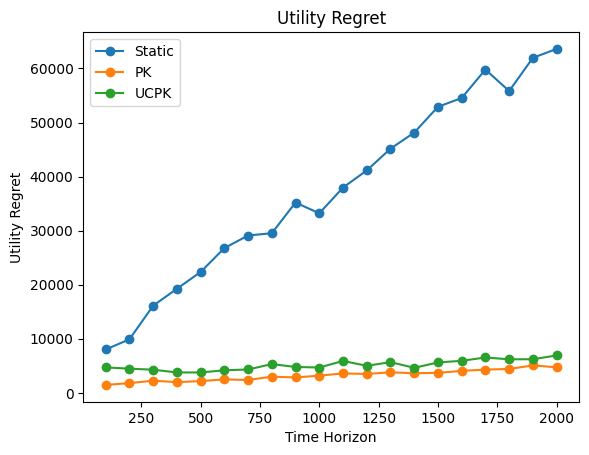

In [ ]:
regrets = np.array(regrets)
Labels = ['Static', 'PK', 'UCPK']
for col in range(3):
    y_values = regrets[:, col]
    plt.plot(timestamp, y_values, marker='o', linestyle='-', label=f'{Labels[col]}')

# Add labels and legend
plt.xlabel('Time Horizon')
plt.ylabel('Utility Regret')
plt.title('Utility Regret')
plt.legend()

# Show the plot
plt.show()

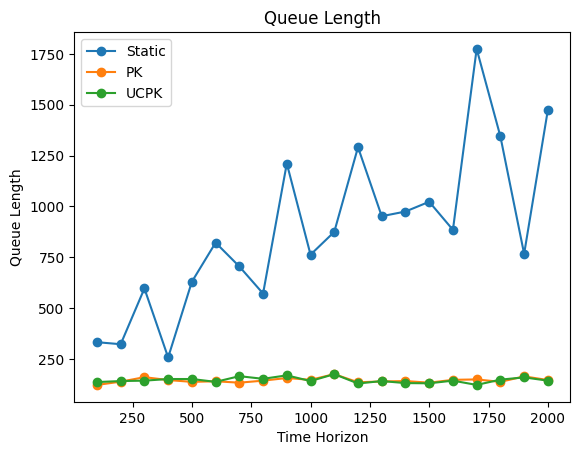

In [ ]:
queue_length = np.array(unfinished_jobs)
Labels = ['Static', 'PK', 'UCPK']
for col in range(3):
    y_values = queue_length[:, col]
    plt.plot(timestamp, y_values, marker='o', linestyle='-', label=f'{Labels[col]}')

# Add labels and legend
plt.xlabel('Time Horizon')
plt.ylabel('Queue Length')
plt.title('Queue Length')
plt.legend()

# Show the plot
plt.show()

####Initial UCPK
#####Not Good Enough

In [ ]:
# def upper_confidence_priority_k(k, Jobs, Ordering_UCPK, servers, T, Service_rates):
#     Ordering_copy = [0] * len(Ordering_UCPK)
#     M = len(servers)

#     t = 0
#     while t<T:
#         print(Ordering_UCPK)
#         if Ordering_UCPK == Ordering_copy:
#             jobs = Jobs[t]
#             priority_k(k, jobs, Ordering_UCPK, servers)
#             for m in range(M):
#                 service_rate = random.choice(Service_rates)
#                 servers[m].process_files(service_rate)
#             Ordering_UCPK = get_new_Ordering(servers)
#             # print(t)
#             # for m in range(M):
#             #     print(servers[m].queue_length, servers[m].total_observed_utilities, servers[m].total_files_processed)
#             t = t + 1
#         else:
#             Ordering_copy = Ordering_UCPK
#             m = 0
#             while t<T and m<M:
#                 jobs = Jobs[t]
#                 servers[m].queue_length += jobs
#                 for mm in range(M):
#                     service_rate = random.choice(Service_rates)
#                     servers[mm].process_files(service_rate)
#                 # print(t, 't')
#                 # for mm in range(M):
#                 #     print(servers[mm].queue_length, servers[mm].total_observed_utilities, servers[mm].total_files_processed)
#                 t = t + 1
#                 m = m + 1
#             Ordering_UCPK = get_new_Ordering(servers)